In [2]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import os
from flask import Flask, flash, request, redirect, url_for
from werkzeug.utils import secure_filename
from flask import send_from_directory
from werkzeug.middleware.shared_data import SharedDataMiddleware

In [3]:
def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask
deeplab_model = load_model()

Using cache found in C:\Users\Youcode/.cache\torch\hub\pytorch_vision_v0.6.0


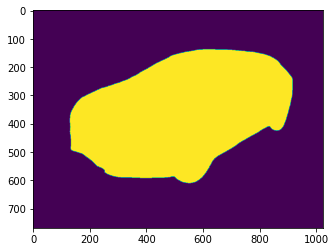

In [5]:
foreground, bin_mask = remove_background(deeplab_model, 'car5.jpg')
plt.imshow(bin_mask)

In [13]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2
  y = (background.size[1]-final_foreground.size[1])/2
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

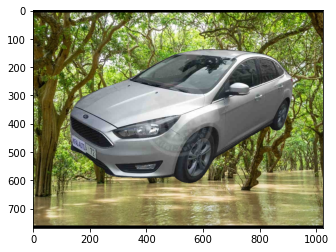

In [21]:
final_image = custom_background('back.jpg', foreground)
plt.imshow(final_image)
#Image.fromarray(final_image).save("gg.png")

In [66]:
UPLOAD_FOLDER = './uploads/'
ALLOWED_EXTENSIONS = {'txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'}

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

In [71]:
def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # check if the post request has the file part
        if 'file' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['file']
        # if user does not select file, browser also
        # submit an empty part without filename
        if file.filename == '':
            flash('No selected file')
            return redirect(request.url)
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
            return redirect(url_for('uploaded_file',
                                    filename=filename))
    return '''
    <!doctype html>
    <title>Upload new File</title>
    <h1>Upload new File</h1>
    <form method=post enctype=multipart/form-data>
      <input type=file name=file>
      <input type=submit value=Upload>
    </form>
    '''


@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'],
                               filename)

app.add_url_rule('/uploads/<filename>', 'uploaded_file',
                 build_only=True)
app.wsgi_app = SharedDataMiddleware(app.wsgi_app, {
    '/uploads':  app.config['UPLOAD_FOLDER']
})

app.run()

AssertionError: View function mapping is overwriting an existing endpoint function: upload_file